In [1]:
import matplotlib.pyplot as plt
import torch.nn as nn
import torch

In [2]:
standard_features = ["DMP_5", "DMP_10", "DMN_5", "DMN_10", "MACD_8_21_5", "AO_5_10",
    "EMA_15", "MA_20", "KAMA_3_2_10", "CO", "C2O2", "C3O3",
    "net_add_ask_size", "net_add_bid_size", "Bollinger_Upper", "Bollinger_Lower"
]

minmax_features = [
    "ADX_10", "ADX_7", "ADX_5", "STOCHk_7_3_3", "STOCHd_7_3_3", "RSI_7", "time_since_open"
]

unscaled_features = ['market_session']
features = standard_features + minmax_features + unscaled_features


In [3]:
class SimpleClassifier(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.lstm = nn.LSTM(input_size, 128, batch_first=True)
        self.fc = nn.Linear(128, 3)
        
    def forward(self, x):
        x, _ = self.lstm(x)
        x = x[:, -1, :]  # Prendre le dernier timestep
        x = self.fc(x)
        return x

In [4]:
# Load model
model_path = "/home/janis/3A/HFTP2/Stock-Prediction-Deep-Leaning/data/models/classification/classification_model_20250226_231905_epoch_3.pt"
model = SimpleClassifier(input_size=len(features))  # Use actual feature count from training
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

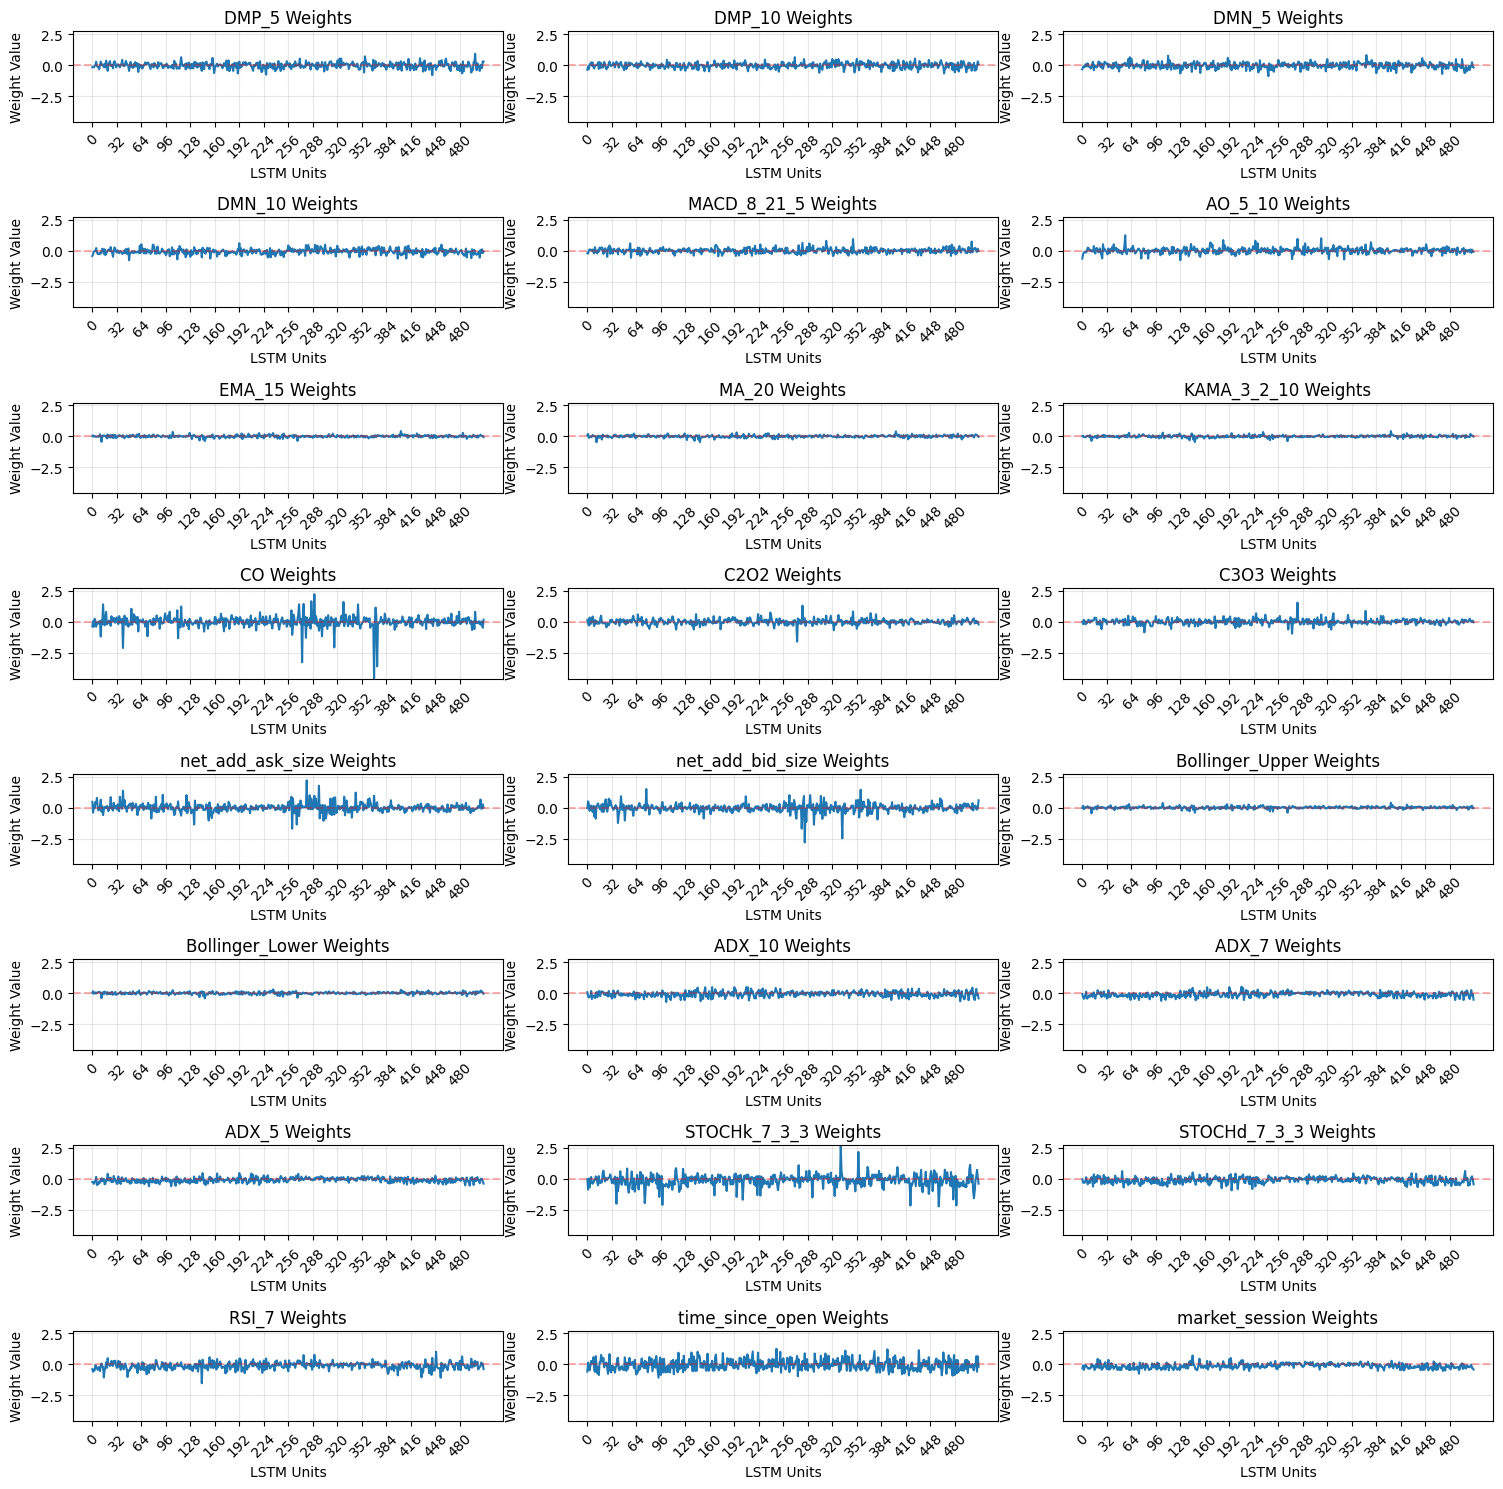

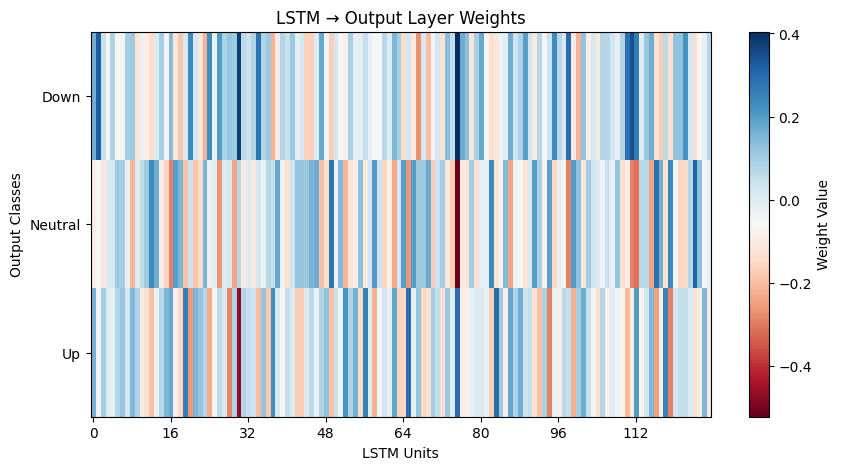

In [11]:
# Extract weights from model layers
lstm_weights = model.lstm.weight_ih_l0.detach().numpy()  # Input -> LSTM weights
lstm_hidden = model.lstm.weight_hh_l0.detach().numpy()   # LSTM hidden weights
fc_weights = model.fc.weight.detach().numpy()            # LSTM -> Output weights

# Create subplots for each feature
n_features = len(features)
n_cols = 3
n_rows = (n_features + n_cols - 1) // n_cols  # Ceiling division

plt.figure(figsize=(15, 15))

for i, feature in enumerate(features):
    plt.subplot(n_rows, n_cols, i+1)
    
    # Get weights for this feature
    feature_weights = lstm_weights[:, i]  # Transpose to get correct dimensions
    
    # Plot weights distribution
    plt.plot(range(len(feature_weights)), feature_weights)
    plt.title(f'{feature} Weights')
    plt.xlabel('LSTM Units')
    plt.ylabel('Weight Value')
    
    # Add horizontal line at y=0
    plt.axhline(y=0, color='r', linestyle='--', alpha=0.3)
    
    # Set consistent y-axis limits across all plots
    plt.ylim(lstm_weights.min(), lstm_weights.max())
    
    # Add grid
    plt.grid(True, alpha=0.3)
    
    # Rotate x-axis labels for better readability
    plt.xticks(range(0, len(feature_weights), 32), rotation=45)

plt.tight_layout()
plt.show()

# Also plot the final layer weights
plt.figure(figsize=(10, 5))
plt.imshow(fc_weights, cmap='RdBu', aspect='auto')
plt.colorbar(label='Weight Value')
plt.title('LSTM → Output Layer Weights')
plt.xlabel('LSTM Units')
plt.ylabel('Output Classes')
plt.xticks(range(0, 128, 16))
plt.yticks(range(3), ['Down', 'Neutral', 'Up'])
plt.show()


In [15]:
from torch.utils.data import Dataset
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import numpy as np
# Feature lists
standard_features = ["DMP_5", "DMP_10", "DMN_5", "DMN_10", "MACD_8_21_5", "AO_5_10",
    "EMA_15", "MA_20", "KAMA_3_2_10", "CO", "C2O2", "C3O3",
    "net_add_ask_size", "net_add_bid_size", "Bollinger_Upper", "Bollinger_Lower"
]

minmax_features = [
    "ADX_10", "ADX_7", "ADX_5", "STOCHk_7_3_3", "STOCHd_7_3_3", "RSI_7", "time_since_open"
]

unscaled_features = ['market_session']
features = standard_features + minmax_features + unscaled_features

# Calculer les indices une seule fois
standard_indices = [features.index(f) for f in standard_features]
minmax_indices = [features.index(f) for f in minmax_features]
unscaled_indices = [features.index(f) for f in unscaled_features]



class TimeSeriesDataset(Dataset):
    def __init__(self, data, target, look_back, oversample=False):
        self.data = data[features].values
        self.targets = data[target].values.astype(int)
        self.look_back = look_back
        
        # Pre-calculate indices
        self.indices = np.arange(len(data) - look_back)
        
        # Fit scalers on all data once
        self.standard_scaler = StandardScaler().fit(self.data[:, standard_indices])
        self.minmax_scaler = MinMaxScaler().fit(self.data[:, minmax_indices])

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        seq_idx = self.indices[idx]
        seq = self.data[seq_idx:seq_idx + self.look_back]
        target = self.targets[seq_idx + self.look_back]
        
        # Transform using pre-fitted scalers
        seq_standard = self.standard_scaler.transform(seq[:, standard_indices])
        seq_minmax = self.minmax_scaler.transform(seq[:, minmax_indices])
        seq_unscaled = seq[:, unscaled_indices]
        
        # Concatenate all features
        seq_normalized = np.hstack((seq_standard, seq_minmax, seq_unscaled))
        return torch.FloatTensor(seq_normalized), torch.LongTensor([target])[0]


In [18]:
# Import required libraries if not already imported
import pdpbox
import os
from pdpbox import pdp, info_plots
import pandas as pd
from datetime import datetime
import numpy as np



In [19]:
import pandas as pd
import ta
import numpy as np
from tqdm import tqdm

market_open = pd.Timestamp("13:30:00").time()
market_close = pd.Timestamp("20:00:00").time()

import os
import dotenv

dotenv.load_dotenv()

stock_name = os.getenv("STOCK_NAME")
print(stock_name)
def load_data(data_path):
    df = pd.read_parquet(data_path)
    df = df.reset_index().set_index("ts_event")
    return df.between_time(market_open, market_close)


def resample_mid_prices(df, sampling_rate):
    """
    Resample the mid_price values by the given sampling rate to get highest, lowest, open, close, and mean prices.

    Parameters:
    df (pd.DataFrame): DataFrame containing the mid_price and depth columns.
    sampling_rate (str): The sampling rate for resampling the data.

    Returns:
    pd.DataFrame: DataFrame containing the resampled mid_price values.
    """
    df_copy = df.copy()
    # Add mid price column (either the bid or the ask if one is missing)
    df_copy["mid_price"] = df_copy[["ask_px_00", "bid_px_00"]].mean(axis=1)
    df_copy["mid_price"] = df_copy["mid_price"].combine_first(df_copy["ask_px_00"])
    df_copy["mid_price"] = df_copy["mid_price"].combine_first(df_copy["bid_px_00"])

    mid_prices_high = df_copy["mid_price"].resample(sampling_rate).max().ffill()
    mid_prices_low = df_copy["mid_price"].resample(sampling_rate).min().ffill()
    mid_prices_close = df_copy["mid_price"].resample(sampling_rate).last().ffill()
    mid_prices_open = df_copy["mid_price"].resample(sampling_rate).first().ffill()

    returns_volatilities = (
        df_copy["mid_price"].pct_change().resample(sampling_rate).std().ffill()
    )

    returns = mid_prices_close.pct_change()

    # Combine the resampled mid_price values into a single DataFrame
    mid_prices = pd.DataFrame(
        {
            "mid_price_high": mid_prices_high,
            "mid_price_low": mid_prices_low,
            "mid_price_close": mid_prices_close,
            "mid_price_open": mid_prices_open,
            "returns": returns,
            "returns_volatility": returns_volatilities,
        }
    )

    return mid_prices


def group_and_pivot_order_sizes(df, sampling_rate):
    """
    Group by ts_event, action, and side, then sum the sizes and pivot the table to create new columns for each combination of action and side.

    Parameters:
    df (pd.DataFrame): DataFrame containing the ts_event, action, side, and size columns.
    sampling_rate (str): The sampling rate for grouping the data.

    Returns:
    pd.DataFrame: DataFrame with pivoted columns for each combination of action and side.
    """
    # Group by ts_event, action, and side, then sum the sizes
    grouped = (
        df.groupby([pd.Grouper(freq=sampling_rate), "action", "side"])["size"]
        .sum()
        .reset_index()
    )

    # Pivot the table to create new columns for each combination of action and side
    order_sizes = grouped.pivot_table(
        index="ts_event", columns=["action", "side"], values="size", fill_value=0
    )

    # Drop unnecessary columns
    columns_to_keep = [
        ("A", "A"),
        ("A", "B"),
        ("C", "A"),
        ("C", "B"),
        ("T", "A"),
        ("T", "B"),
    ]
    order_sizes = order_sizes[columns_to_keep]

    # Define mappings for action and side
    action_mapping = {"A": "add", "C": "cancel", "T": "trade"}
    side_mapping = {"A": "ask", "B": "bid"}

    # Rename columns
    order_sizes.columns = [
        f"{action_mapping[action]}_{side_mapping[side]}_size"
        for action, side in order_sizes.columns
    ]

    order_sizes["net_add_ask_size"] = (
        order_sizes["add_ask_size"] - order_sizes["cancel_ask_size"]
    )
    order_sizes["net_add_bid_size"] = (
        order_sizes["add_bid_size"] - order_sizes["cancel_bid_size"]
    )

    order_sizes.drop(
        columns=["add_ask_size", "add_bid_size", "cancel_ask_size", "cancel_bid_size"],
        inplace=True,
    )

    return order_sizes


def compute_technical_indicators(df):
    """
    Compute technical indicators for a given DataFrame with OHLC-like structure.
    """
    # Make a copy of the DataFrame to avoid modifying the original
    df = df.copy()

    df["Returns"] = df["mid_price_close"].pct_change()
    df["Target_close"] = np.sign(df["Returns"]) + 1

    ### TREND INDICATORS ###
    df["ADX_5"] = ta.trend.ADXIndicator(
        df["mid_price_high"], df["mid_price_low"], df["mid_price_close"], window=5
    ).adx()
    df["ADX_7"] = ta.trend.ADXIndicator(
        df["mid_price_high"], df["mid_price_low"], df["mid_price_close"], window=7
    ).adx()
    df["ADX_10"] = ta.trend.ADXIndicator(
        df["mid_price_high"], df["mid_price_low"], df["mid_price_close"], window=10
    ).adx()
    df["DMP_5"] = ta.trend.ADXIndicator(
        df["mid_price_high"], df["mid_price_low"], df["mid_price_close"], window=5
    ).adx_pos()
    df["DMP_10"] = ta.trend.ADXIndicator(
        df["mid_price_high"], df["mid_price_low"], df["mid_price_close"], window=10
    ).adx_pos()
    df["DMN_5"] = ta.trend.ADXIndicator(
        df["mid_price_high"], df["mid_price_low"], df["mid_price_close"], window=5
    ).adx_neg()
    df["DMN_10"] = ta.trend.ADXIndicator(
        df["mid_price_high"], df["mid_price_low"], df["mid_price_close"], window=10
    ).adx_neg()

    # Aroon Indicator requires both high and low prices
    df["AROONU_7"] = ta.trend.AroonIndicator(
        df["mid_price_high"], df["mid_price_low"], window=7
    ).aroon_up()
    df["AROOND_7"] = ta.trend.AroonIndicator(
        df["mid_price_high"], df["mid_price_low"], window=7
    ).aroon_down()

    # Open-Low and Open-High calculations
    df["OLL3"] = df["mid_price_open"] - df["mid_price_low"].rolling(window=3).min()
    df["OLL5"] = df["mid_price_open"] - df["mid_price_low"].rolling(window=5).min()
    df["OLL10"] = df["mid_price_open"] - df["mid_price_low"].rolling(window=10).min()
    df["OLL15"] = df["mid_price_open"] - df["mid_price_low"].rolling(window=15).min()
    df["OHH3"] = df["mid_price_high"].rolling(window=3).max() - df["mid_price_open"]
    df["OHH5"] = df["mid_price_high"].rolling(window=5).max() - df["mid_price_open"]

    ### OSCILLATORS ###
    df["STOCHk_7_3_3"] = ta.momentum.StochasticOscillator(
        df["mid_price_high"],
        df["mid_price_low"],
        df["mid_price_close"],
        window=7,
        smooth_window=3,
    ).stoch()
    df["STOCHd_7_3_3"] = ta.momentum.StochasticOscillator(
        df["mid_price_high"],
        df["mid_price_low"],
        df["mid_price_close"],
        window=7,
        smooth_window=3,
    ).stoch_signal()

    # Avoid NaN Stochastic values
    df["STOCHk_7_3_3"] = df["STOCHk_7_3_3"].ffill()
    df["STOCHd_7_3_3"] = df["STOCHd_7_3_3"].ffill()

    df["MACD_8_21_5"] = ta.trend.MACD(
        df["mid_price_close"], window_slow=21, window_fast=8, window_sign=5
    ).macd_diff()
    df["RSI_7"] = ta.momentum.RSIIndicator(df["mid_price_close"], window=7).rsi()
    df["AO_5_10"] = ta.momentum.AwesomeOscillatorIndicator(
        df["mid_price_high"], df["mid_price_low"], window1=5, window2=10
    ).awesome_oscillator()

    ### MOVING AVERAGES ###
    df["EMA_15"] = ta.trend.EMAIndicator(
        df["mid_price_close"], window=15
    ).ema_indicator()
    df["HMA_10"] = ta.trend.WMAIndicator(
        df["mid_price_close"], window=10
    ).wma()  # HMA is not directly available in 'ta', using WMA as a placeholder
    df["KAMA_3_2_10"] = ta.momentum.KAMAIndicator(
        df["mid_price_close"], window=3, pow1=2, pow2=10
    ).kama()
    df["MA_10"] = ta.trend.SMAIndicator(
        df["mid_price_close"], window=10
    ).sma_indicator()
    df["MA_20"] = ta.trend.SMAIndicator(
        df["mid_price_close"], window=20
    ).sma_indicator()

    # Rolling CO (Close - Open)
    for w in [3, 4, 5, 6]:
        df[f"rmCO({w})"] = (
            (df["mid_price_close"] - df["mid_price_open"]).rolling(window=w).mean()
        )

    ### VOLATILITY INDICATORS ###
    df["Bollinger_Upper"] = ta.volatility.BollingerBands(
        df["mid_price_close"], window=20, window_dev=2
    ).bollinger_hband()
    df["Bollinger_Lower"] = ta.volatility.BollingerBands(
        df["mid_price_close"], window=20, window_dev=2
    ).bollinger_lband()
    df["U_minus_L"] = df["Bollinger_Upper"] - df["Bollinger_Lower"]
    df["MA20dSTD"] = df["mid_price_close"].rolling(window=20).std()

    ### OTHER INDICATORS ###
    df["CO"] = df["mid_price_close"] - df["mid_price_open"]
    df["C1O1"] = df["CO"].shift(1)
    df["C2O2"] = df["CO"].shift(2)
    df["C3O3"] = df["CO"].shift(3)
    df["range"] = df["mid_price_high"] - df["mid_price_low"]
    df["OH1"] = df["mid_price_high"].shift(1) - df["mid_price_open"].shift(1)

    return df.dropna()


def add_time_features(combined_df):
    """
    Add time-based features to the combined DataFrame.

    Parameters:
        combined_df (pd.DataFrame): The input DataFrame with a DateTime index.

    Returns:
        combined_df (pd.DataFrame): The DataFrame with added time-based features.
    """
    combined_df = combined_df.copy()

    # Add market open time for each day (9:30 AM)
    combined_df["market_open_time"] = combined_df.index.normalize() + pd.Timedelta(
        hours=9, minutes=30
    )

    # Compute seconds since market open
    combined_df["time_since_open"] = (
        combined_df.index - combined_df["market_open_time"]
    ).dt.total_seconds()

    # Encode day of the week as one-hot vectors
    combined_df["day_of_week"] = (
        combined_df.index.weekday
    )  # Extract day of the week (0=Monday, 6=Sunday)
    combined_df = pd.get_dummies(combined_df, columns=["day_of_week"], prefix="dow")

    # Convert one-hot columns to integers (0 or 1)
    one_hot_columns = [col for col in combined_df.columns if col.startswith("dow_")]
    combined_df[one_hot_columns] = combined_df[one_hot_columns].astype(int)

    # Add market session feature (morning = 0, afternoon = 1)
    combined_df["market_session"] = (
        combined_df["time_since_open"] > 3.5 * 3600  # 3.5 hours after market open
    ).astype(int)

    combined_df.drop(columns=["market_open_time"], inplace=True)

    return combined_df


def process_and_combine_data(
    start_date,
    end_date,
    data_folder="/home/janis/3A/EA/HFT_QR_RL/data/smash4/DB_MBP_10/" + stock_name,
    sampling_rate="1s",
):
    """
    Process and combine trade data for a given date range.

    Parameters:
        start_date (str or datetime): Start date of the date range (inclusive).
        end_date (str or datetime): End date of the date range (inclusive).
        market_open (str): Market open time (e.g., "09:30").
        market_close (str): Market close time (e.g., "16:00").
        data_folder (str): Folder containing the parquet files.
        sampling_rate (str): Resampling rate for mid prices and order sizes (e.g., "5s").

    Returns:
        all_data (pd.DataFrame): Combined DataFrame containing processed data for all trade days.
    """
    # Convert start_date and end_date to datetime
    start_date = pd.to_datetime(start_date)
    end_date = pd.to_datetime(end_date)

    # Generate business date range
    date_range = pd.bdate_range(start=start_date, end=end_date)
    
    # Generate file paths
    data_paths = [
        f"{data_folder}/{stock_name}_{date.strftime('%Y-%m-%d')}_xnas-itch.parquet"
        for date in date_range
    ]
    # Initialize list to store daily data
    trade_days_data = []

    # Process each file
    for path in tqdm(data_paths):
        if os.path.exists(path):
            # Load data
            df = load_data(path)

            # Compute order sizes
            order_sizes = group_and_pivot_order_sizes(df, sampling_rate=sampling_rate)

            # Compute mid prices
            mid_prices = resample_mid_prices(df, sampling_rate=sampling_rate)

            # Reindex order sizes to match mid prices
            order_sizes = order_sizes.reindex(mid_prices.index, fill_value=0)

            # Compute technical indicators
            technical_indicators = compute_technical_indicators(mid_prices)

            df_combined = order_sizes.join(technical_indicators, how="inner")

            trade_days_data.append(df_combined)

    all_data = pd.concat(trade_days_data)

    return add_time_features(all_data)

AAPL


In [31]:

sampling_rate = "500ms"
prediction_column = "Target_close"
look_back = 64
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Load data for September 18
data_path = "/home/janis/3A/EA/HFT_QR_RL/data/smash4/DB_MBP_10/AAPL/AAPL_2024-10-18_xnas-itch.parquet"
df = pd.read_parquet(data_path)

# Preprocess data similar to training
df = process_and_combine_data("2024-10-18", "2024-10-22", 
                            data_folder="/home/janis/3A/EA/HFT_QR_RL/data/smash4/DB_MBP_10/AAPL",
                            sampling_rate=sampling_rate)

# Create dataset
test_dataset = TimeSeriesDataset(df, prediction_column, look_back)


100%|██████████| 3/3 [00:12<00:00,  4.27s/it]


In [46]:
df.count()

trade_ask_size        140187
trade_bid_size        140187
net_add_ask_size      140187
net_add_bid_size      140187
mid_price_high        140187
mid_price_low         140187
mid_price_close       140187
mid_price_open        140187
returns               140187
returns_volatility    140187
Returns               140187
Target_close          140187
ADX_5                 140187
ADX_7                 140187
ADX_10                140187
DMP_5                 140187
DMP_10                140187
DMN_5                 140187
DMN_10                140187
AROONU_7              140187
AROOND_7              140187
OLL3                  140187
OLL5                  140187
OLL10                 140187
OLL15                 140187
OHH3                  140187
OHH5                  140187
STOCHk_7_3_3          140187
STOCHd_7_3_3          140187
MACD_8_21_5           140187
RSI_7                 140187
AO_5_10               140187
EMA_15                140187
HMA_10                140187
KAMA_3_2_10   

In [ ]:
1
# Function to make predictions
def predict_func(model, X):
    model.eval()
    with torch.no_grad():
        X = torch.FloatTensor(X).to(device)
        outputs = model(X)
        probs = torch.softmax(outputs, dim=1)
        return probs.cpu().numpy()


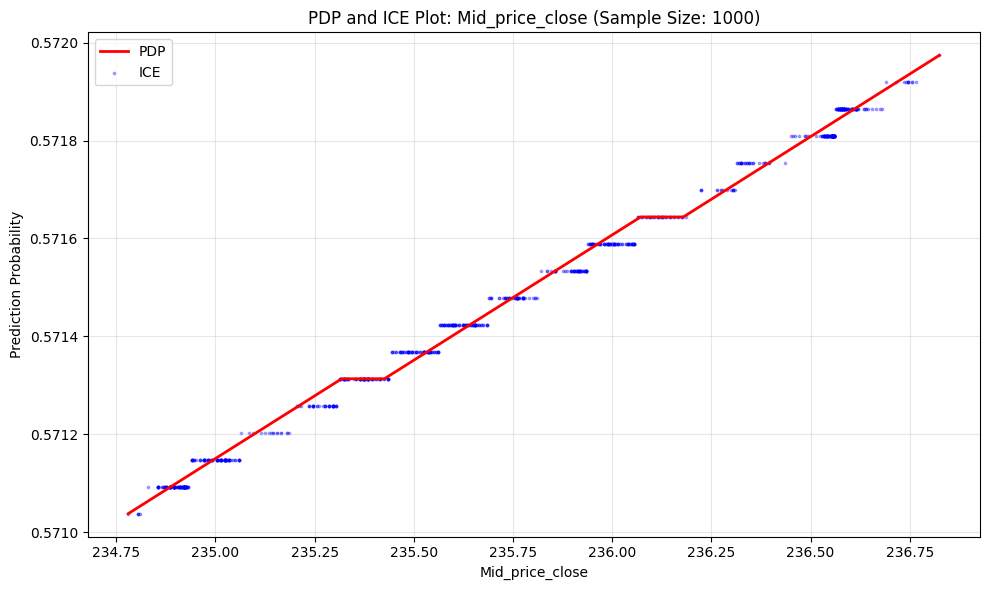

<Figure size 640x480 with 0 Axes>

In [52]:
# Create simple PDP plot for AAPL
plt.figure(figsize=(10, 6))

# Get a single important feature and sample a subset of data
feature = 'mid_price_close'
sample_size = 1000  # Reduce sample size to avoid memory issues
df_sample = df.sample(n=sample_size, random_state=42)

# Get feature values from the sampled dataframe
X = df_sample[feature].values
X = X.reshape(-1, 1)

# Create feature grid for ICE/PDP with fewer points
X_grid = np.linspace(X.min(), X.max(), num=20).reshape(-1,1)

# Get predictions for each grid point
y_preds = []
for x in X_grid:
    # Create model input with all features, but vary only the target feature
    X_model = np.zeros((1, look_back, 24))  # 24 features expected by model
    feature_idx = df.columns.get_loc(feature)
    X_model[..., feature_idx] = x
    
    # Move model to same device as input tensors
    model = model.to(device)
    pred = predict_func(model, X_model)
    y_preds.append(pred[0,1]) # Get probability of positive class
y_preds = np.array(y_preds)

# Plot PDP
plt.plot(X_grid, y_preds, 'r-', label='PDP', linewidth=2)

# Plot ICE with reduced data
X_ice = np.zeros((len(X), look_back, 24))
X_ice[..., feature_idx] = X.reshape(-1, 1)
y_ice = predict_func(model, X_ice)
plt.scatter(X, y_ice[:,1], alpha=0.3, s=3, c='blue', label='ICE')

plt.xlabel(feature.capitalize())
plt.ylabel('Prediction Probability') 
plt.title(f'PDP and ICE Plot: {feature.capitalize()} (Sample Size: {sample_size})')
plt.grid(True, alpha=0.3)
plt.legend()

plt.tight_layout()
plt.show()

# Save plot
os.makedirs('results/torch_classification', exist_ok=True)
plt.savefig('results/torch_classification/pdp_ice_plot_sampled.png')